# OpenSCM

This notebook provides a demo of OpenSCM. 

<div class="alert alert-danger">
  <strong>Danger!</strong> All the models have errors in the way they're being run at the moment. Do not use in production.
</div>

In [1]:
# NBVAL_IGNORE_OUTPUT
import numpy as np


from openscm import run
from openscm.scenarios import rcps
from openscm.units import unit_registry

from openscm.scmdataframebase import LongIamDataFrame

<IPython.core.display.Javascript object>

In [2]:
import seaborn as sns
sns.set(style="darkgrid")

Emissions scenarios in OpenSCM should be provided as `ScmDataFrame`'s. These focus on simple climate model data whilst retaining many of the data analysis tools present in pyam. To get access to all the tools, an `ScmDataFrame` can be cast to an `IamDataFrame` via its `to_iamdataframe()` method.

In [3]:
type(rcps)

openscm.scmdataframebase.ScmDataFrameBase

In [4]:
# NBVAL_IGNORE_OUTPUT
rcps.head()

,,,,,time,1765-01-01 00:00:00,1766-01-01 00:00:00,1767-01-01 00:00:00,1768-01-01 00:00:00,1769-01-01 00:00:00,1770-01-01 00:00:00,1771-01-01 00:00:00,1772-01-01 00:00:00,1773-01-01 00:00:00,1774-01-01 00:00:00,...,2491-01-01 00:00:00,2492-01-01 00:00:00,2493-01-01 00:00:00,2494-01-01 00:00:00,2495-01-01 00:00:00,2496-01-01 00:00:00,2497-01-01 00:00:00,2498-01-01 00:00:00,2499-01-01 00:00:00,2500-01-01 00:00:00
model,scenario,region,variable,unit,climate_model,,,,,,,,,,,,,,,,,,,,,
AIM,RCP60,World,Emissions|BC,Mt BC / yr,unspecified,0.0,0.106998,0.133383,0.159847,0.186393,0.213024,0.239742,0.26655,0.29345,0.320446,...,4.3615,4.3615,4.3615,4.3615,4.3615,4.3615,4.3615,4.3615,4.3615,4.3615
IMAGE,RCP26,World,Emissions|BC,Mt BC / yr,unspecified,0.0,0.106998,0.133383,0.159847,0.186393,0.213024,0.239742,0.26655,0.29345,0.320446,...,3.3578,3.3578,3.3578,3.3578,3.3578,3.3578,3.3578,3.3578,3.3578,3.3578
MESSAGE,RCP85,World,Emissions|BC,Mt BC / yr,unspecified,0.0,0.106998,0.133383,0.159847,0.186393,0.213024,0.239742,0.26655,0.29345,0.320446,...,4.2496,4.2496,4.2496,4.2496,4.2496,4.2496,4.2496,4.2496,4.2496,4.2496
MiniCAM,RCP45,World,Emissions|BC,Mt BC / yr,unspecified,0.0,0.106998,0.133383,0.159847,0.186393,0.213024,0.239742,0.26655,0.29345,0.320446,...,3.8621,3.8621,3.8621,3.8621,3.8621,3.8621,3.8621,3.8621,3.8621,3.8621
AIM,RCP60,World,Emissions|C2F6,kt C2F6 / yr,unspecified,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.0370,0.0370,0.0370,0.0370,0.0370,0.0370,0.0370,0.0370,0.0370,0.0370


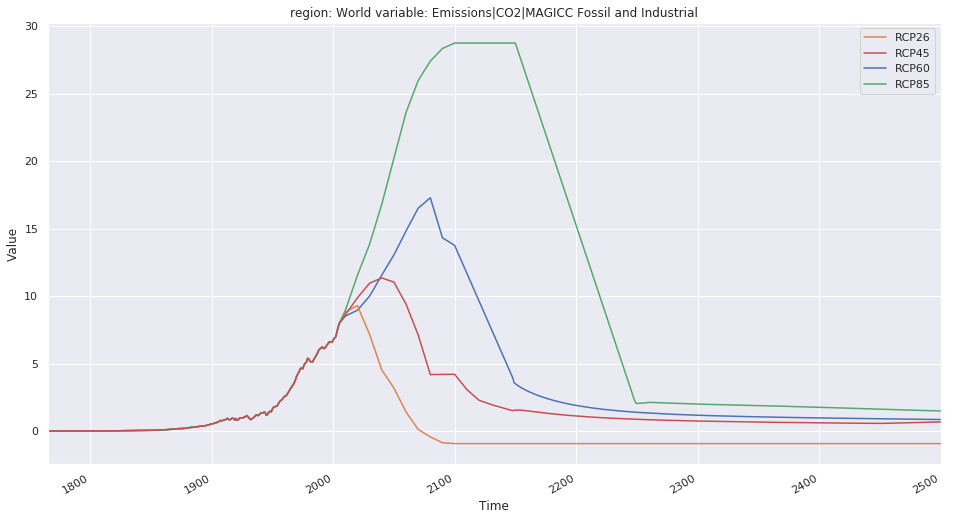

In [5]:
rcps.filter(
    variable="Emissions|CO2|*Fossil*"
).line_plot(
    x="time", 
    figsize=(16, 9), 
    color="scenario"
);

The run function provides easy access to each of the simple climate models.

In [6]:
# NBVAL_IGNORE_OUTPUT
ph99_paras = [
    {"ecs": (("World",), e * unit_registry("K"))} 
    for e in np.arange(1.5, 4.5, 0.3)
]
res = run(
    rcps, 
    {
        "PH99": ph99_paras,
    },
);

N/A% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--PH99 does not use ('Emissions', 'BC')
PH99 does not use ('Emissions', 'C2F6')
PH99 does not use ('Emissions', 'C6F14')
PH99 does not use ('Emissions', 'CCl4')
PH99 does not use ('Emissions', 'CF4')
PH99 does not use ('Emissions', 'CFC11')
PH99 does not use ('Emissions', 'CFC113')
PH99 does not use ('Emissions', 'CFC114')
PH99 does not use ('Emissions', 'CFC115')
PH99 does not use ('Emissions', 'CFC12')
PH99 does not use ('Emissions', 'CH3Br')
PH99 does not use ('Emissions', 'CH3CCl3')
PH99 does not use ('Emissions', 'CH3Cl')
PH99 does not use ('Emissions', 'CH4')
PH99 does not use ('Emissions', 'CO')
PH99 does not use ('Emissions', 'HCFC141b')
PH99 does not use ('Emissions', 'HCFC142b')
PH99 does not use ('Emissions', 'HCFC22')
PH99 does not use ('Emissions', 'HFC125')
PH99 does not use ('Emissions', 'HFC134a')
PH99 does not use ('Emissions', 'HFC143a')
PH99 does not use ('Emissions', 'HFC227ea')
PH99 does n

running PH99

running RCP26


| |                #                                  | 9 Elapsed Time: 0:00:01
/ |#                                                  | 0 Elapsed Time: 0:00:00

running RCP45


| |              #                                    | 9 Elapsed Time: 0:00:01
/ |#                                                  | 0 Elapsed Time: 0:00:00

running RCP60


| |           #                                       | 9 Elapsed Time: 0:00:01
/ |#                                                  | 0 Elapsed Time: 0:00:00

running RCP85


| |           #                                       | 9 Elapsed Time: 0:00:01
100% (4 of 4) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (1 of 1) |##########################| Elapsed Time: 0:00:06 Time:  0:00:06


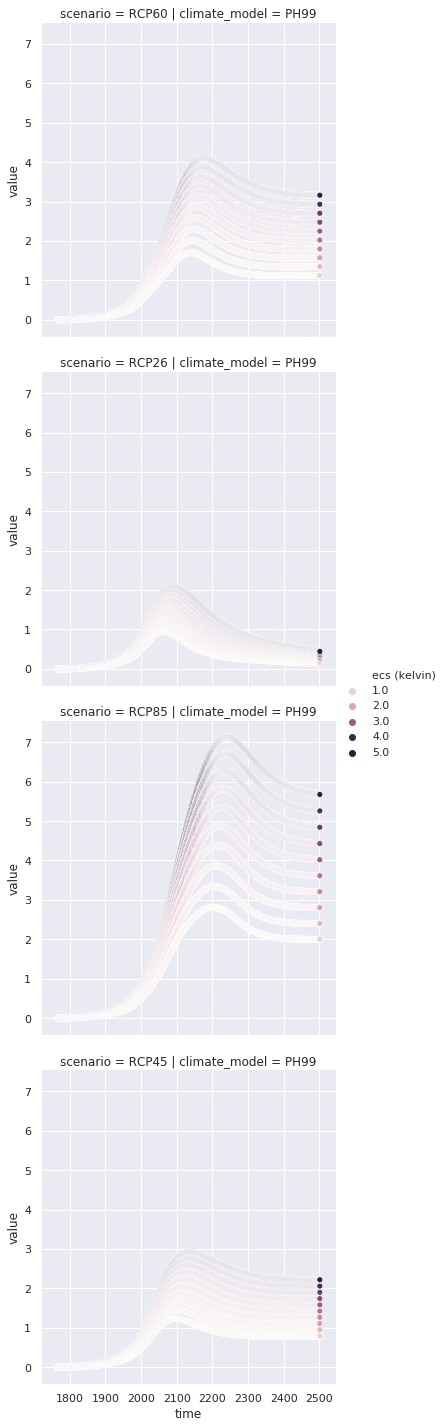

In [7]:
sns.set(rc={'figure.figsize': (16, 9)})
df = LongIamDataFrame(res.filter(variable="Surface Temperature").timeseries(meta=[
    "ecs (kelvin)",
    "climate_model",
    "model",
    "scenario",
    "variable",
    "region",
    "unit",
])).data
sns.relplot(
    data=df,
    x="time",
    y="value",
    hue="ecs (kelvin)", 
    row="scenario",
    col="climate_model"
);